# Set-up

## Imports

In [1]:
# --- Standard library ---
from datetime import datetime
import pickle

# --- Scientific computation ---
import numpy as np

# --- Data handling and visualization ---
import pandas as pd  # Dataframe tools
from tabulate import tabulate  # Pretty printing for dataframes

import seaborn as sns  # Easier plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

## Globals

In [2]:
today = datetime.today().strftime("%Y%m%d")

# --- Visualization ---
rc_dict = {
  "savefig.dpi": 900,  # Saved figure dots-per-inch. 600 is "HD"
  "savefig.facecolor": "white",  # This, combined with transparent setting, keeps saved figs from looking like trash on dark backgrounds 
  "savefig.transparent": False,
  "figure.figsize": (14, 10),  # Default (width, height) of figure
}
plt.rcParams.update(rc_dict)

# Data preprocessing

## Embedding Results

In [3]:
# Load dataframes
ex09_S = pd.read_parquet("../../results/dataframes/dataframe_EMB_ex09-Sv1.0_DK_20221010.parquet")
ex09_R = pd.read_parquet("../../results/dataframes/dataframe_EMB_ex09-Rv1.1_DK_20221011.parquet")
ex10_S = pd.concat([
    pd.read_parquet("../../results/dataframes/dataframe_EMB_ex10-Sv1.0-inverse_DK_20221010.parquet"),  # gamma, inverse
    pd.read_parquet("../../results/dataframes/dataframe_EMB_ex10-Sv1.0-negexp_DK_20221010.parquet"),  # gamma, negexp
    pd.read_parquet("../../results/dataframes/dataframe_EMB_ex10-Sv1.0-mu-inverse_DK_20221010.parquet"),  # mu, inverse
    pd.read_parquet("../../results/dataframes/dataframe_EMB_ex10-Sv1.0-mu-negexp_DK_20221010.parquet"),  # mu, negexp
])
ex10_R = pd.concat([
    pd.read_parquet("../../results/dataframes/dataframe_EMB_ex10-Rv1.0_DK_20221010.parquet"),  # first couple layers
    pd.read_parquet("../../results/dataframes/dataframe_EMB_ex10-Rv1.0_DK_20221012.parquet"),  # remaining layers
])

# Add embedding identifying column
ex09_S["Embedding"] = ["N2V-dPC"] * len(ex09_S)
ex09_R["Embedding"] = ["N2V-dPC"] * len(ex09_R)
ex10_S["Embedding"] = ["LE-PC"] * len(ex10_S)
ex10_R["Embedding"] = ["LE-PC"] * len(ex10_R)

# Concat based on datasets
df_S = pd.concat([ex09_S, ex10_S])
df_R = pd.concat([ex09_R, ex10_R])

## Prior Results

In [4]:
# Load prior results
with open("../../results/MEC/figure2b_data.pk", "rb") as _fh:
    df_f2b = pickle.load(_fh)
with open("../../results/MEC/figure2c_data.pk", "rb") as _fh:
    df_f2c = pickle.load(_fh)

# Reformat synthetic data
mus = []
gammas = []
pfis = []
aurocs = []
accs = []

for gamma, data_ in df_f2b.items():
    for idx, pfi in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        mus.append(0.1)
        gammas.append(gamma)
        pfis.append(pfi)
        aurocs.append(data_[-1][idx])
        accs.append(data_[-2][idx])

for mu, data_ in df_f2c.items():
    for idx, pfi in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        mus.append(mu)
        gammas.append(2.1)
        pfis.append(pfi)
        aurocs.append(data_[-1][idx])
        accs.append(data_[-2][idx])

df_f2 = pd.DataFrame({
    "avg_k": [5]*len(mus),
    "gamma": gammas,
    "mu": mus,
    "metric": ["DC"]*len(mus),
    "pfi": pfis,
    "rep": [1]*len(mus),
    "AUROC": aurocs,
    "Accuracy": accs,
    "Embedding": ["DC"]*len(mus)
})

In [5]:
# Load prior results
with open("../../results/MEC/figure4c_data.pk", "rb") as _fh:
    df_f4c = pickle.load(_fh)
with open("../../results/MEC/figure4d_data.pk", "rb") as _fh:
    df_f4d = pickle.load(_fh)

# Reformat real data
systems = []
embeddings = []
alphas = []
betas = []
pfis = []
aurocs = []
accs = []

for ((embedding, alpha, beta), data_) in df_f4c.items():
    for idx, pfi in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        systems.append("celegans")
        embeddings.append(embedding)
        alphas.append(alpha)
        betas.append(beta)
        pfis.append(pfi)
        aurocs.append(data_[-1][idx])
        accs.append(data_[-2][idx])

for ((embedding, alpha, beta), data_) in df_f4d.items():
    for idx, pfi in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        systems.append("london")
        embeddings.append(embedding)
        alphas.append(alpha)
        betas.append(beta)
        pfis.append(pfi)
        aurocs.append(data_[-1][idx])
        accs.append(data_[-2][idx])

df_f4 = pd.DataFrame({
    "system": systems,
    "alpha": alphas,
    "beta": betas,
    "dimension": [0]*len(systems),
    "metric": embeddings,
    "pfi": pfis,
    "rep": [1]*len(systems),
    "AUROC": aurocs,
    "Accuracy": accs,
    "Embedding": embeddings,
})

## Other adjustments

In [6]:
# Concatenate Embedding and Bayesian results
df_S = pd.concat([df_S, df_f2])
df_R = pd.concat([df_R, df_f4])

# Reindex
df_S.index = range(len(df_S))
df_R.index = range(len(df_R))

# Remove NaNs
df_R = df_R.fillna(0)

# Cast as correct type
df_S = df_S.astype({
    'avg_k': 'int8',
    'rep': 'int8',
    'mu': 'float32',
    'gamma': 'float32',
    'pfi': 'float32',
    'metric': 'category',
})
df_R = df_R.astype({
    'dimension': 'int8',
    'rep': 'int8',
    'pfi': 'float32',
    'metric': 'category',
    "Embedding": "category"
})

# Figures

## Synthetic Datasets

Text(0.5, 20.80000000000002, 'PFI')

<Figure size 1008x720 with 0 Axes>

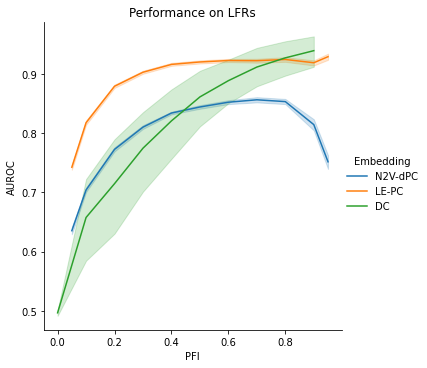

In [7]:
plt.figure()
sns.relplot(
    data=df_S, kind="line",
    x="pfi", y="AUROC",
    hue="Embedding",
)

plt.title("Performance on LFRs")
plt.ylabel("AUROC")
plt.xlabel("PFI")

# plt.savefig(f"../../results/plots/line_auroc-pfi_EMB_ex10-S_DK_{today}.png")

Text(0.5, 20.799999999999983, 'PFI')

<Figure size 1008x720 with 0 Axes>

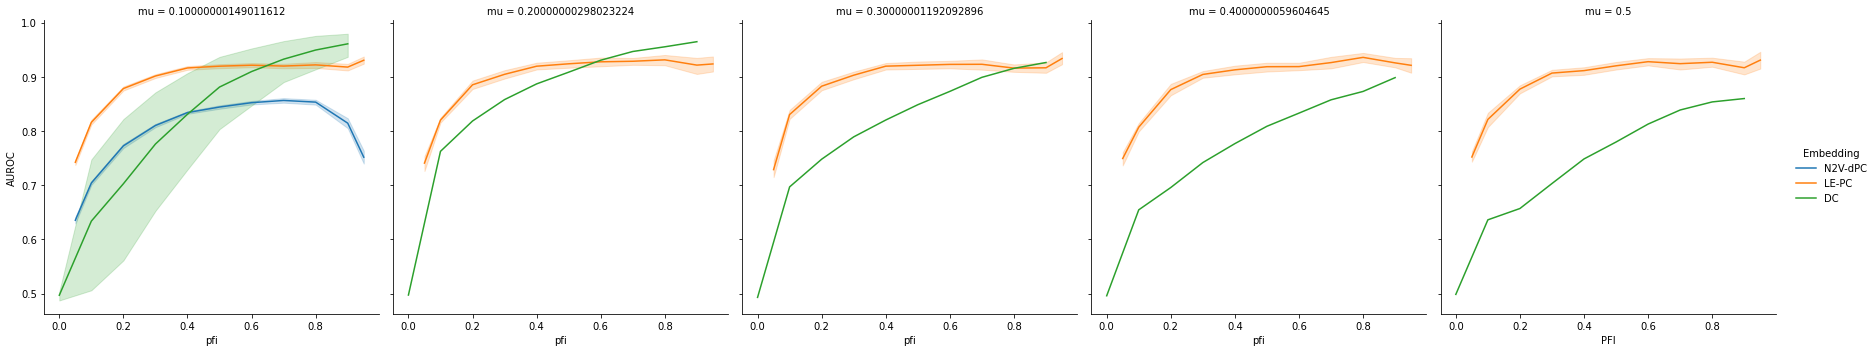

In [8]:
plt.figure()
sns.relplot(
    data=df_S, kind="line",
    x="pfi", y="AUROC",
    hue="Embedding",
    col="mu"
)

# plt.title("Performance on LFRs")
plt.ylabel("AUROC")
plt.xlabel("PFI")

<Figure size 1008x720 with 0 Axes>

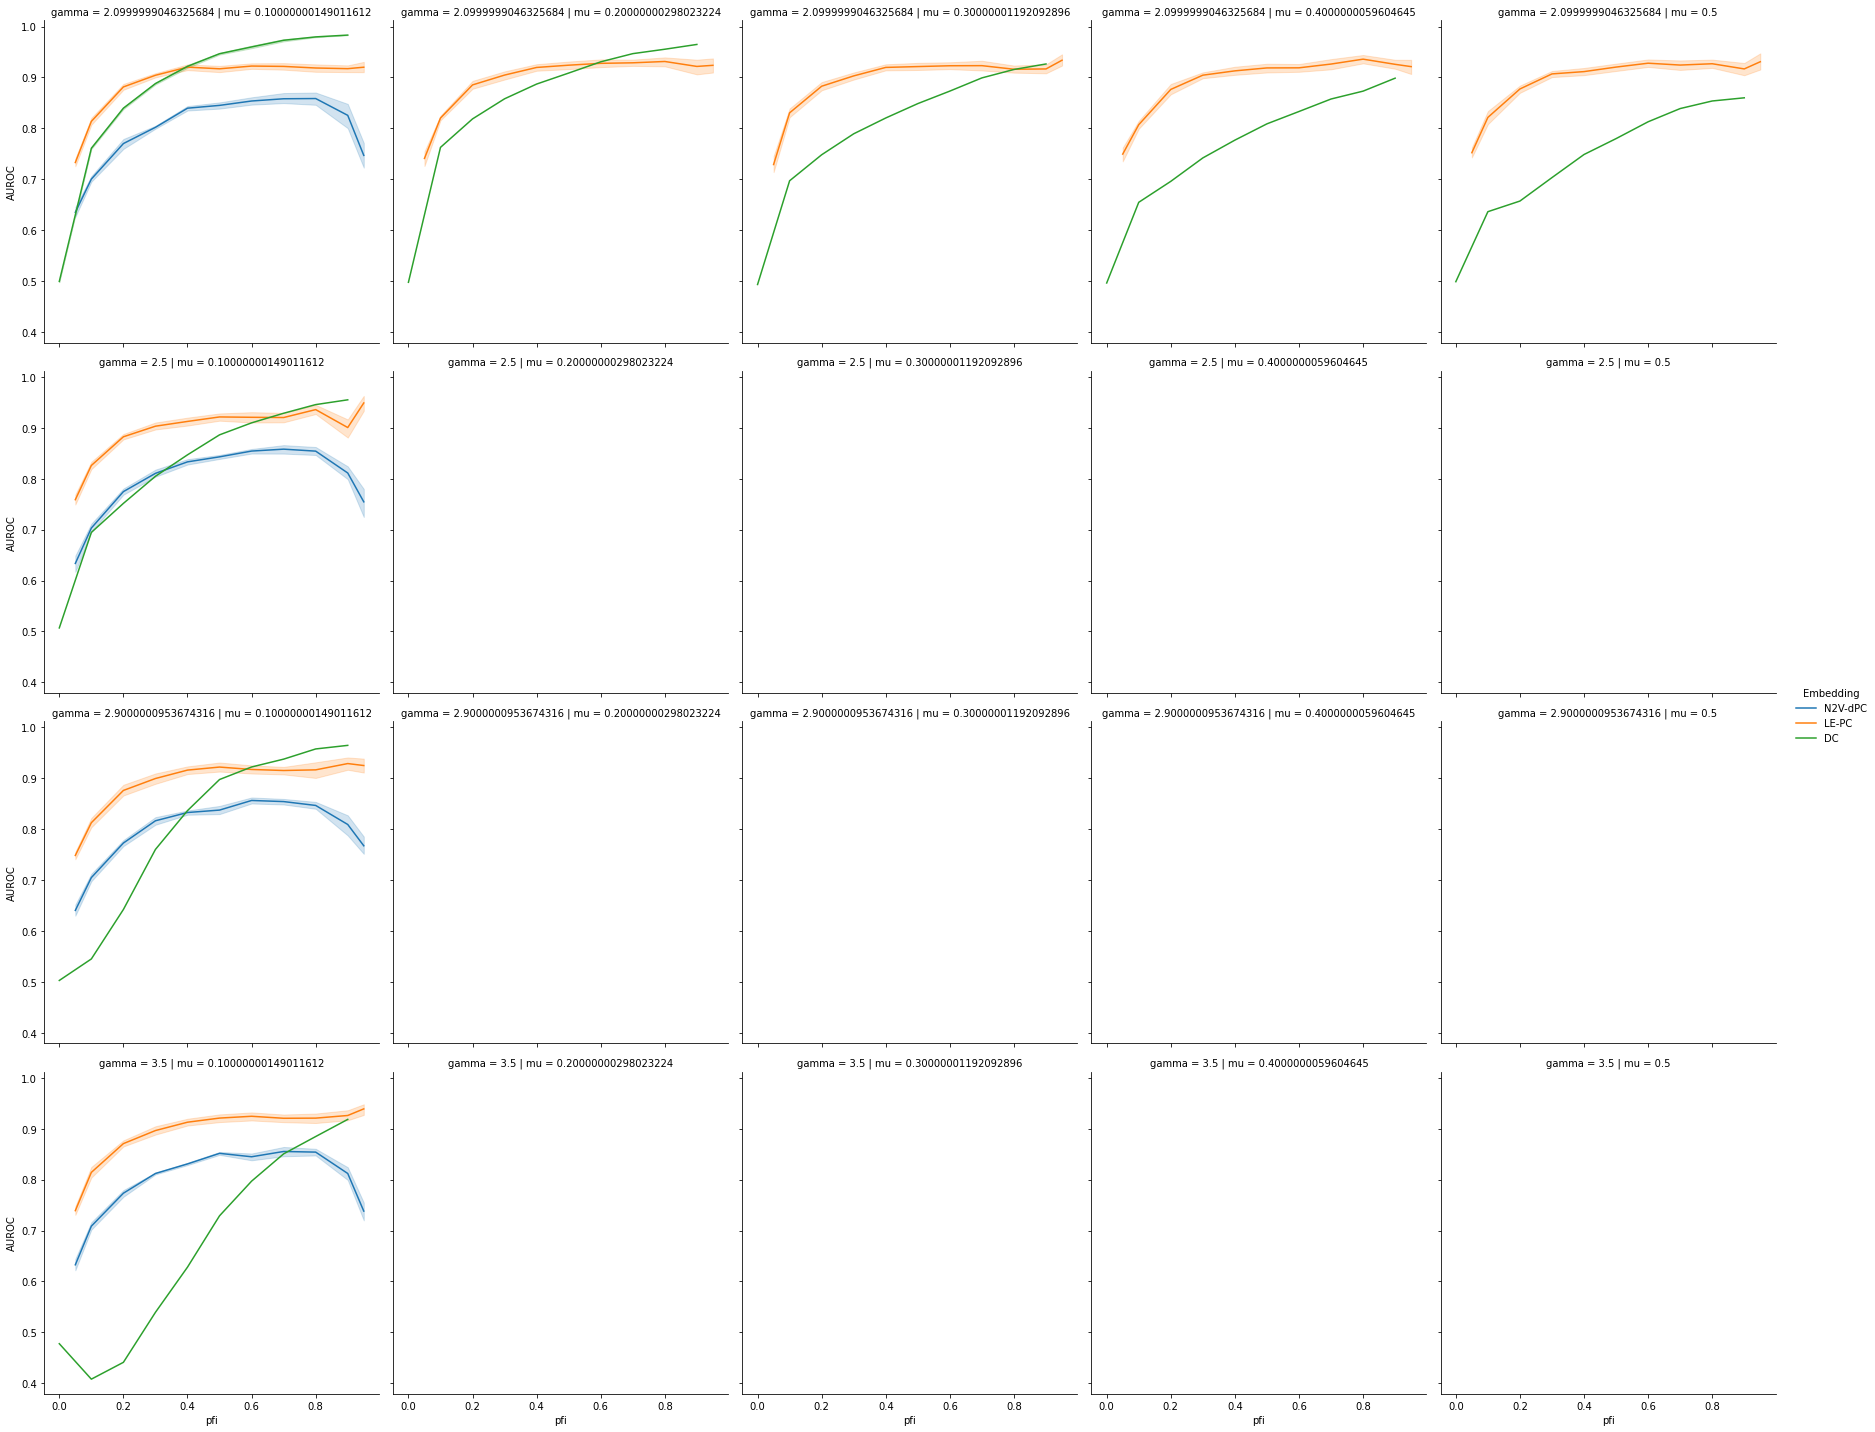

In [9]:
plt.figure()
sns.relplot(
    data=df_S, kind="line",
    x="pfi", y="AUROC",
    hue="Embedding",
    col="mu",
    row="gamma"
)

## Real Datasets

Text(0.5, 20.799999999999983, 'PFI')

<Figure size 1008x720 with 0 Axes>

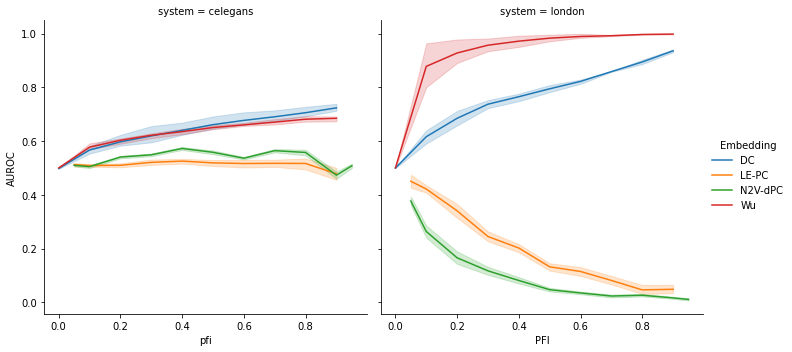

In [10]:
plt.figure()
sns.relplot(
    data=df_R, kind="line",
    x="pfi", y="AUROC",
    hue="Embedding",
    col="system",
)

# plt.title("Performance on Real datasets")
plt.ylabel("AUROC")
plt.xlabel("PFI")

# plt.savefig(f"../../results/plots/line_auroc-pfi_EMB_ex10-S_DK_{today}.png")

Text(0.5, 20.800000000000296, 'PFI')

<Figure size 1008x720 with 0 Axes>

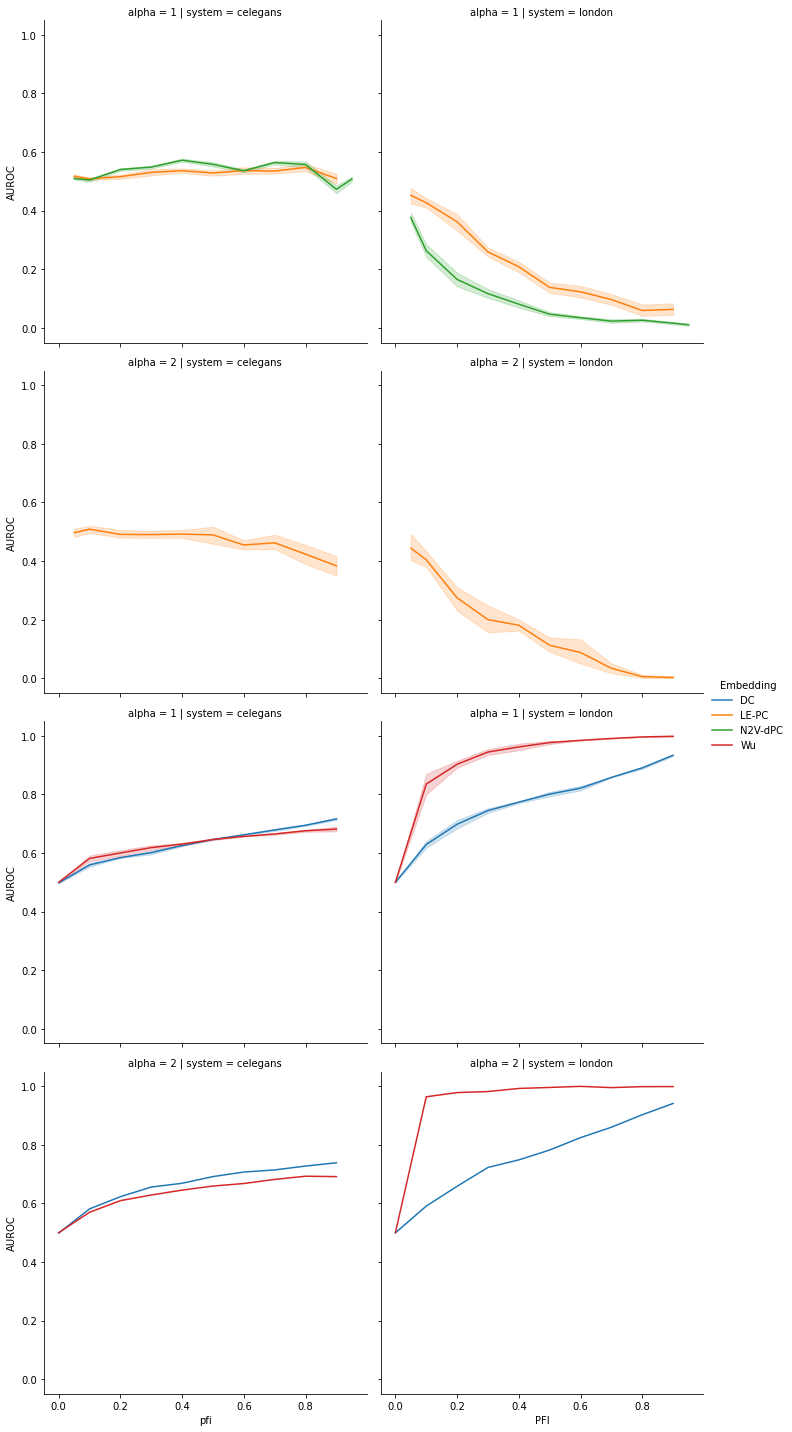

In [11]:
plt.figure()
sns.relplot(
    data=df_R, kind="line",
    x="pfi", y="AUROC",
    hue="Embedding",
    col="system",
    row="alpha"
)

# plt.title("Performance on Real datasets")
plt.ylabel("AUROC")
plt.xlabel("PFI")
